In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

In [4]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [5]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)

/var/folders/9m/3m9g9yzs77j2m_79z47fjdr00000gq/T/ipykernel_27049/178743430.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new)


In [6]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [7]:
df.ip.value_counts().head()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
Name: ip, dtype: int64

In [8]:
df.ip.value_counts(normalize=True).head() #normalize = True gives the percentage of each

97.105.19.58      0.858420
173.173.113.51    0.075762
72.181.113.170    0.043855
72.181.105.81     0.017599
68.201.219.223    0.001502
Name: ip, dtype: float64

In [9]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [10]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()

,count,proba
97.105.19.58,11999,0.858420
173.173.113.51,1059,0.075762
72.181.113.170,613,0.043855
72.181.105.81,246,0.017599
68.201.219.223,21,0.001502


<AxesSubplot:>

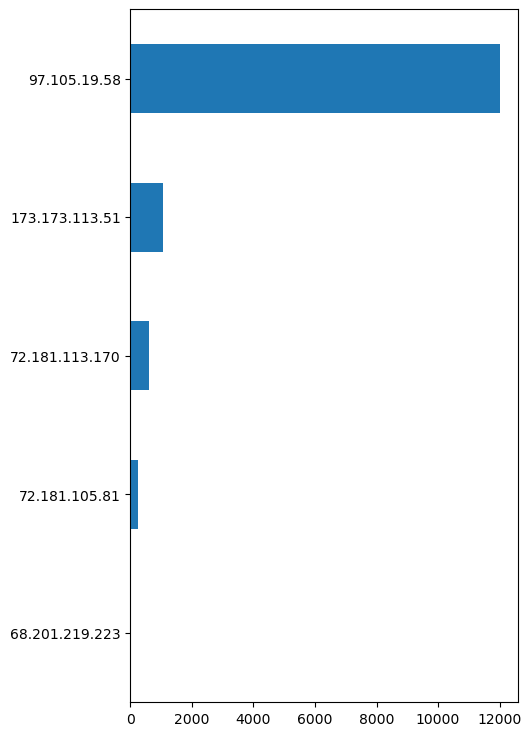

In [12]:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))

In [20]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [21]:
status_given_ip[status_given_ip.status_code != '200']

,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
19,95.31.16.121,301,1.000000
21,97.105.15.120,301,1.000000
23,97.105.19.58,499,0.001167


In [22]:
df[df.ip == '97.105.15.120']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-18 19:42:41,97.105.15.120,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0,0.002441


In [23]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


In [24]:
df

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246
...,...,...,...,...,...,...,...,...
2019-04-17 12:55:14,97.105.19.58,GET,/api/v1/sales?page=71,HTTP/1.1,200,510166,python-requests/2.21.0,0.486532
2019-04-21 10:02:41,95.31.18.119,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0,1.099591
2019-04-17 19:36:41,95.31.16.121,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0,0.000958


In [27]:
value_counts_and_frequencies(df.user_agent)

,count,proba
python-requests/2.21.0,12005,0.858850
python-requests/2.20.1,1911,0.136715
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",34,0.002432
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0,8,0.000572
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots),7,0.000501
Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",4,0.000286
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36",2,0.000143
Python-urllib/3.7,1,0.000072
